# Import everything needed for MORO

In [5]:
from ema_workbench import (Model, RealParameter, Policy, Constant, Scenario, ScalarOutcome)
from ema_workbench.util import ema_logging, save_results, load_results
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from problem_formulation import get_model_for_problem_formulation
from ema_workbench import (MultiprocessingEvaluator, ema_logging, perform_experiments) # parallel computing

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline  
# With this backend, the output of plotting commands is displayed inline within frontends like the Jupyter notebook, 
# directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document.


ema_logging.log_to_stderr(ema_logging.INFO)

'''
For different list of outcomes:
# 0 = 2-objective PF
# 1 = 3-objective PF
# 2 = 5-objective PF
# 3 = Disaggregate over locations
# 4 = Disaggregate over time
# 5 = Fully disaggregated
'''

dike_model, planning_steps = get_model_for_problem_formulation(1) # assign problem_formulation_id


In [12]:
# for levers in dike_model.levers:
#     print(levers)

# Define the robustness metrics

In [45]:
import functools

percentile90 = functools.partial(np.percentile, q=90)

def mean_rob(data):
    return np.sum(data)/(data.shape[0]*1e9)

MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE 

robustness_functions = [ScalarOutcome('Expected Number of Deaths', kind=MINIMIZE,
                             variable_name='Expected Number of Deaths', function=percentile90),
                        ScalarOutcome('Expected Annual Damage', kind=MINIMIZE,
                             variable_name='Expected Annual Damage', function=percentile90),
                       ScalarOutcome('Total Investment Costs', kind=MINIMIZE,
                             variable_name='Total Investment Costs', function=mean_rob),]

# Expected Annual Damage
# RfR Investment Costs
# Evacuation Costs
# Expected Number of Deaths
# Total Investment Costs

# Check the number of needed scenarios

In [46]:
%%time 
from ema_workbench import ema_logging, MultiprocessingEvaluator

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=40,               
                                            policies=6)


[MainProcess/INFO] pool started
[MainProcess/INFO] performing 40 scenarios * 6 policies * 1 model(s) = 240 experiments
[MainProcess/INFO] 24 cases completed
[MainProcess/INFO] 48 cases completed
[MainProcess/INFO] 72 cases completed
[MainProcess/INFO] 96 cases completed
[MainProcess/INFO] 120 cases completed
[MainProcess/INFO] 144 cases completed
[MainProcess/INFO] 168 cases completed
[MainProcess/INFO] 192 cases completed
[MainProcess/INFO] 216 cases completed
[MainProcess/INFO] 240 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


Wall time: 1min 50s


In [47]:
save_results(results, "perform_experiments40scen6pol.tar.gz")

[MainProcess/INFO] results saved successfully to C:\Users\georg\OneDrive\Υπολογιστής\OneDrive\TU Delft\4.3ModelBasedDecisionMaking\Giorgio\perform_experiments40scen6pol.tar.gz


In [48]:
results = load_results(".\perform_experiments40scen6pol.tar.gz")
experiments, outcomes = results

[MainProcess/INFO] results loaded succesfully from C:\Users\georg\OneDrive\Υπολογιστής\OneDrive\TU Delft\4.3ModelBasedDecisionMaking\Giorgio\perform_experiments40scen6pol.tar.gz


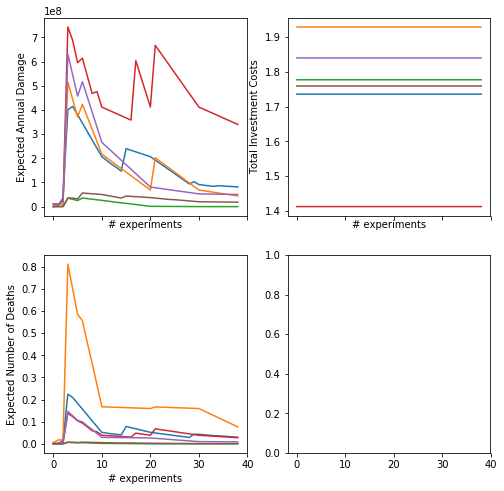

In [49]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,8),
                        sharex=True)
axes = [axes[0,0],axes[0,1],axes[1,0],axes[1,1]]                             #axes[1,1]

robustness_funcs = {"Expected Number of Deaths": percentile90,
                    "Expected Annual Damage": percentile90,
                    "Total Investment Costs": mean_rob}


for ax, (outcome, value) in zip(axes, outcomes.items()):
    for policy in np.unique(experiments['policy']):
        logical = experiments['policy'] == policy
        data = value[logical]
        
        robustness = []
      
        for i in range(1, data.shape[0]):
            robustness.append(robustness_funcs[outcome](data[0:i]))
        ax.plot(robustness, label=policy)
    ax.set_xlabel("# experiments")
    ax.set_ylabel(outcome)

In [28]:
data.shape[0]
np.sum(data)/data.shape[0]
# np.sum(data)/(data.shape[0]*1e9)

0.005098566429634912

In [26]:
data.shape

200